In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2010")
    test = data[test_mask].cases
    return train, test

In [3]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

cr_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangRai'].resample('W').size()
cr_dengues_df = pd.DataFrame(cr_dengues,columns=['cases'])
cr_train_test = split_data(cr_dengues_df)
cr_dengues_train, cr_dengues_test = cr_train_test[0], cr_train_test[1]

cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])
cm_train_test = split_data(cm_dengues_df)
cm_dengues_train, cm_dengues_test = cm_train_test[0], cm_train_test[1]

all_dengues = provinces_df.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])
all_train_test = split_data(all_dengues_df)
all_dengues_train, all_dengues_test = all_train_test[0], all_train_test[1]

In [4]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$\sigma\,(w_{i}\cdot x_{i}) = \sum_{i=0}^{n} w_{i} x_{i}$$

$$Seasonal\,Part_{0} =\,\sin(\dfrac{\pi}{52}\,(x_{\,week\,to\,predict} - c)) + k$$

$$cases = (\sigma(w\cdot x) \,\times Seasonal\,Part) +\, k$$

## predict n weeks ahead by using the new set of betas
 
0-25: 29, 1-26: 30, 2-27: 31, 3-28:32, 4-29:33, 5-30:34

if the length of data is N, length of prediction would be N - (lag + week ahead)

ex. test case has length of 20, week ahead is 2, and lag is 4, the length of prediction would be 14

$$g(\bar{x}) = \bar{x}_{n+4}$$

$$x_{n+4} = g(x_{n},\,x_{n-1},\,x_{n-2},\,x_{n-3},\,....\,x_{n-LAG})$$

In [53]:
def guess(w,x_week,y_case):
    
    def sigma(w,y_case):
        pad_y = np.concatenate(([1],np.array(y_case)))
        all_cases = np.dot(w[:-3],pad_y)
        return all_cases

    def season_cos_sq(w,x_week):
        pi = np.math.pi
        coeff = pi/52.
        inside = (coeff*x_week) - (coeff*w[-2])
        cosine_sq = np.math.cos(inside)**2
        score = cosine_sq + w[-3]
        return score    
    
    return (sigma(w,y_case) * season_cos_sq(w,x_week)) + w[-1]

def get_alphas(LAG,train,constant):
    W_CASE = LAG + 1
    W_POP = 1
    W_SEASON = 2
    BETAS_SET = W_POP + W_CASE + W_SEASON # addition of ALL_WS betas

    # use poison instead of least square
    def cost(w):
        ret = 0
        for week_no in range(len(train)-(LAG+3)): # 4 weeks ahead of current week. LAG+(week ahead - 1)
            week_nth = week_no+LAG+3 # future week starting 0th week. (week ahead - 1)
#             print "week_nth", week_nth # 29
#             print 'wtp',train[week_no:week_no+LAG][-1] # train[0:29][-1] == train[28]
            real_case = train[week_nth] # 4 weeks ahead of current week. LAG+(week ahead - 1)
#             print train[week_nth] # train[29]
            predicted_case = guess(w,week_nth,train[week_no:week_no+LAG])#guess(26ws,week 29th,train[:26])
            sigma_sq = real_case + 1 # assume poisson and avoid division by zero
            ret += ((real_case - predicted_case)**2)/float(sigma_sq)
#         print ret
        return ret

    seasonality_starters = [0.75,20] # [amplitude,constant,period,phase]
    arr = np.array([0.]*W_CASE) #  betas
#     arr = np.array(pd.read_csv('starter_ws.csv')['starter_ws'][:-1])
    arr = np.append(arr,seasonality_starters) # 29 betas
    arr = np.append(arr,constant) # 30 betas
    w = minimize(cost,arr)
    return w


In [52]:
# print cm_dengues_train[0:26][-1]
# print cm_dengues_train[25]
# print cm_dengues_train[:34]
print cm_dengues_train[:34]
print cm_dengues_train[29]

date
2003-01-05      1
2003-01-12      2
2003-01-19      5
2003-01-26      0
2003-02-02      2
2003-02-09      2
2003-02-16      1
2003-02-23      4
2003-03-02      3
2003-03-09      3
2003-03-16      2
2003-03-23      3
2003-03-30      3
2003-04-06      2
2003-04-13      3
2003-04-20      6
2003-04-27     10
2003-05-04     10
2003-05-11     18
2003-05-18     31
2003-05-25     25
2003-06-01     49
2003-06-08     76
2003-06-15     91
2003-06-22    101
2003-06-29    100
2003-07-06     97
2003-07-13     89
2003-07-20     95
2003-07-27    124
2003-08-03    104
2003-08-10    103
2003-08-17     82
2003-08-24     74
Freq: W-SUN, Name: cases, dtype: int64
124


In [51]:
get_alphas(26,cm_dengues_train,-9.26e-01)

week_nth 29
wtp 100
124
week_nth 30
wtp 97
104
week_nth 31
wtp 89
103
week_nth 32
wtp 95
82
week_nth 33
wtp 124
74
week_nth 34
wtp 104
39
week_nth 35
wtp 103
51
week_nth 36
wtp 82
54
week_nth 37
wtp 74
45
week_nth 38
wtp 39
24
week_nth 39
wtp 51
27
week_nth 40
wtp 54
29
week_nth 41
wtp 45
27
week_nth 42
wtp 24
24
week_nth 43
wtp 27
28
week_nth 44
wtp 29
20
week_nth 45
wtp 27
8
week_nth 46
wtp 24
12
week_nth 47
wtp 28
4
week_nth 48
wtp 20
3
week_nth 49
wtp 8
11
week_nth 50
wtp 12
5
week_nth 51
wtp 4
1
week_nth 52
wtp 3
0
week_nth 53
wtp 11
0
week_nth 54
wtp 5
0
week_nth 55
wtp 1
0
week_nth 56
wtp 0
0
week_nth 57
wtp 0
2
week_nth 58
wtp 0
1
week_nth 59
wtp 0
0
week_nth 60
wtp 0
1
week_nth 61
wtp 2
0
week_nth 62
wtp 1
2
week_nth 63
wtp 0
1
week_nth 64
wtp 1
2
week_nth 65
wtp 0
0
week_nth 66
wtp 2
2
week_nth 67
wtp 1
4
week_nth 68
wtp 2
3
week_nth 69
wtp 0
1
week_nth 70
wtp 2
2
week_nth 71
wtp 4
2
week_nth 72
wtp 3
6
week_nth 73
wtp 1
8
week_nth 74
wtp 2
12
week_nth 75
wtp 2
32
week_nth 76

KeyboardInterrupt: 

In [54]:
cm_26 = get_alphas(26,cm_dengues_train,-9.26e-01)

In [8]:
cm_26_wid_wtp = get_alphas(26,cm_dengues_train,-9.26e-01)


In [30]:
cm_26.x

array([  3.09777961e+00,  -1.02208128e-02,  -1.31192513e-02,
        -5.97403596e-03,   7.91525469e-02,  -7.76587886e-02,
        -1.40507313e-02,  -7.24369918e-05,  -7.39008321e-02,
         6.94758682e-02,   1.57308925e-02,   3.43871064e-02,
        -8.53202360e-02,   5.87135091e-02,   1.25874902e-01,
        -6.12266218e-02,   1.86050868e-01,  -8.25779645e-02,
        -9.40390513e-02,   4.74162130e-02,  -1.24832780e-01,
         2.98427510e-02,  -1.11764464e-01,  -1.35281785e-01,
         4.00621954e-02,   1.73027937e-01,   1.02598129e+00,
         2.67254269e-01,   2.33300722e+01,  -1.20647233e+00])

In [66]:
cm_dengues_test[:26]

date
2010-01-03     10
2010-01-10     12
2010-01-17     11
2010-01-24      7
2010-01-31     10
2010-02-07      8
2010-02-14      5
2010-02-21      9
2010-02-28      8
2010-03-07      6
2010-03-14     11
2010-03-21      9
2010-03-28     13
2010-04-04     10
2010-04-11     12
2010-04-18      8
2010-04-25     11
2010-05-02     12
2010-05-09     26
2010-05-16     33
2010-05-23     31
2010-05-30     56
2010-06-06     81
2010-06-13    122
2010-06-20    124
2010-06-27    127
Freq: W-SUN, Name: cases, dtype: int64

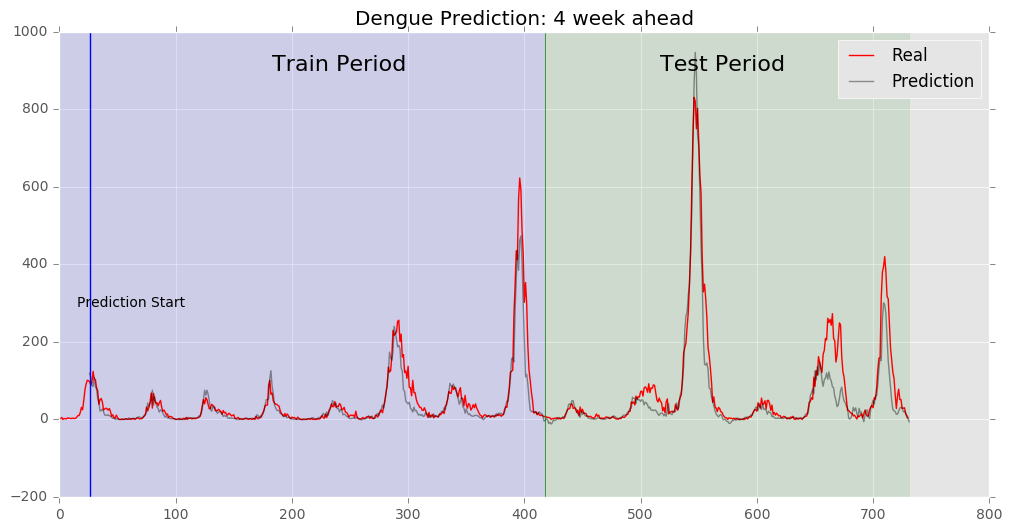

In [81]:
NWEEKS = 26
prediction_4week = []
# 2007 onward
train = cm_dengues_train
test = cm_dengues_test
train_test = cm_dengues_df.cases #cm_dengues_df.cases
# print train_test
for i in range(len(train_test)-(NWEEKS-1)):
    nth_week = i+NWEEKS+3
#     print week_to_predict+3
#     print train_test[i:i+NWEEKS][0],train_test[i:i+NWEEKS][-1]
    res = 0
    res = guess(cm_26.x,nth_week,train_test[i:i+NWEEKS])
    prediction_4week.append(res)
    
prediction_4week
    
test_none = np.array(train_test)
test_none = np.append(test_none,[None]*0)
make_line(26,test_none,prediction_4week,'Dengue Prediction: 4 week ahead',"","")
plt.axvspan(0, len(train), color='blue', alpha=0.1)
plt.text((len(train)/2)-25,900,'Train Period',size=16)
plt.axvline(len(train)+1,linewidth=0.5, color='green')
plt.text(len(train)+100,900,'Test Period',size=16)
plt.axvspan(len(train)+1, len(train_test), color='green', alpha=0.1)
# plt.axvline(416)
# plt.axvline(420)

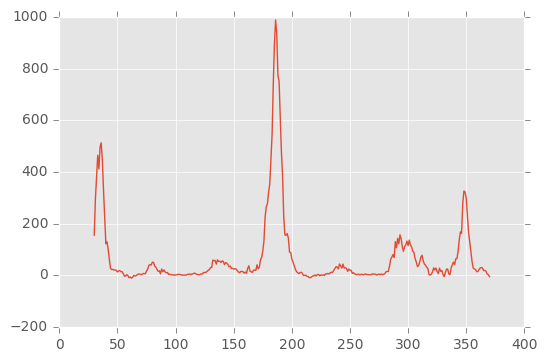

In [71]:
plt.plot([i for i in range(30,(30+len(prediction_4week)))],prediction_4week)

In [140]:
temp_cases = [i+1 for i in range(20)]
# n_week_ahead = 4
lag = 7
ct = 0
for week_no in range(len(temp_cases)-(lag-1)):
    print 'week_no',week_no+lag+3
    print temp_cases[week_no:week_no+lag]
    ct+=1
#     print 'real',temp_cases[week_no+lag+3]
ct

week_no 10
[1, 2, 3, 4, 5, 6, 7]
week_no 11
[2, 3, 4, 5, 6, 7, 8]
week_no 12
[3, 4, 5, 6, 7, 8, 9]
week_no 13
[4, 5, 6, 7, 8, 9, 10]
week_no 14
[5, 6, 7, 8, 9, 10, 11]
week_no 15
[6, 7, 8, 9, 10, 11, 12]
week_no 16
[7, 8, 9, 10, 11, 12, 13]
week_no 17
[8, 9, 10, 11, 12, 13, 14]
week_no 18
[9, 10, 11, 12, 13, 14, 15]
week_no 19
[10, 11, 12, 13, 14, 15, 16]
week_no 20
[11, 12, 13, 14, 15, 16, 17]
week_no 21
[12, 13, 14, 15, 16, 17, 18]
week_no 22
[13, 14, 15, 16, 17, 18, 19]
week_no 23
[14, 15, 16, 17, 18, 19, 20]


14